# ENSF 519.01 Applied Data Science 
**Assignment 5** - 100 marks

**Due:** November 25, 05.00 pm.


**IMPORTANT NOTE: each task must be implemented as asked, even if there are other easier or better solutions.**

**How to deliver:**
Edit this file and write your solutions in sections specified with `# Your solution`. Test your code and when you are done, submit this notebook as an `.ipynb` file to D2L dropbox. 



## Spam detection 

Here we have a dataset of text messages which are labeled as spam or ham. We want to read the dataset and use a clustering algorithm to tell spam messages from non-spam (ham!) ones. The data is in tsv format with two columns: label and text. TSV is just like csv but the column values are separated by a tab instead of a `,`. 

1. Read the file into a dataframe
2. Convert `label` column to pandas categorical data type
3. complete the `clean_text` function and apply it to the text column. To clean up:
    1. Make it lowercase
    2. Remove all of the punctuations (use `string.punctuation` and `str.translate`)
    3. Replace repetetive whitespaces with just one blank charachter (e.g.: 'i    had \tan apple' -> 'i had an apple')
    4. Removing the stop words
    5. Stem each word using snowball stemmer provided in `nltk`


In [70]:
import re, string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt 
%matplotlib inline


stemmer = SnowballStemmer("english")
def clean_text(text):
    """
    text: str, returns: str
    """
    # Make text lowercase
    text = text.lower()
    
    # Remove all of the punctuations
    translation = str.maketrans("", "", string.punctuation)
    text = text.translate(translation)
    
    # Replace repetetive which space with just one blank character
    text = re.sub("\s\s+", " ", text).strip()
    
    # Remove stopping words
    text = " ".join(list(filter(lambda x: x not in ENGLISH_STOP_WORDS, text.split(" "))))
    
    # Stem each word using the snowball stemmer
    text = " ".join(list(map(lambda x: stemmer.stem(x), text.split(" "))))
    return text


sms = pd.read_csv('sms.tsv', sep='\t', names=['label', 'text'])
sms["text"] = sms["text"].apply(clean_text)
print(sms.dtypes)  # Expected: label category text object dtype: object
sms

label    object
text     object
dtype: object


,label,text
0,ham,jurong point crazi avail bugi n great world la...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkts 2...
3,ham,u dun say earli hor u c say
4,ham,nah dont think goe usf live
...,...,...
5567,spam,2nd time tri 2 contact u u won £750 pound priz...
5568,ham,ü b go esplanad fr home
5569,ham,piti mood soani suggest
5570,ham,guy did bitch act like id interest buy week ga...


Split the data into train and test sets (20% test 80% training), use `stratify` parameter to ensure that there is an even split for both categories. X values should be the vectors and y values the labels.


Complete `build_tfidf` function below to make and fit a TF-IDF vectorizer with `min_df` = 2. This function is later called in the loop. 

Similar to previous assignments and problems, change the random state in a for loop from 0 to 9, in each iteration:

1. The vectorizer instance is created on the training set. Convert the `X_train` and `X_test` by calling the `transform` method. You don't have to refit the transformer in the loop.
2. train and evaluate these classifiers: 

    * LogisticRegression 
    * LinearSVC
    * Naïve Bayes, with Bernoulli distribution
    * Decision tree, use 20 for `min_samples_split` to prevent overfitting
    * Random Forest, with a 100 estimators and use min_samples_split like above

 

Use `random_state`s from in `[0, 5)` in classifier contruction for those which accept this parameter.
Keep record of these scores in a pandas dataframe and make a boxplot to compare them. Set ylim to `(0.85, 1)`. 

**You should do all these inside the `fit_eval` and `build_tfidf` functions. Don't add any lines of code before or after it.** Also it doesn't need to return any values.

Time:  63.827567305008415


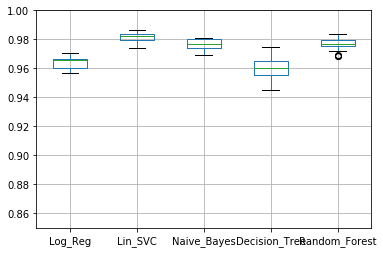

In [75]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import timeit

def build_tfidf(X_train):
    vectorizer = TfidfVectorizer(min_df=2).fit(X_train)
    # Fit the vectorizer here
    return (vectorizer,)  # A tuple with only one item


def fit_eval(get_vectorizer):
    start = timeit.default_timer()
    # Column names: 'Logistic Regression', 'Linear SVC', 'Naïve Bayes', 'Decision tree', 'Random Forest'
    results = []
    for split_seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(sms["text"], sms["label"], random_state=split_seed ,train_size=0.8, stratify=sms["label"])
        vectorizer = get_vectorizer(X_train)[0]
        if len(get_vectorizer(X_train)) == 2:            
            count_vectorizer = get_vectorizer(X_train)[1]
            X_train = vectorizer.transform(count_vectorizer.transform(X_train))
            X_test = vectorizer.transform(count_vectorizer.transform(X_test))
        else:           
            # Apply the transformations using `vectorizer` instance above
            X_train = vectorizer.transform(X_train)
            X_test = vectorizer.transform(X_test)
        
        for ran_state in range(0, 5):
            scores = {}
            # LogisticRegression
            lr = LogisticRegression(random_state=ran_state, solver='lbfgs').fit(X_train, y_train)
            lr_score = lr.score(X_test, y_test)
            scores["Log_Reg"] = lr_score

            # LinearSVC
            lsvc = LinearSVC(random_state=ran_state).fit(X_train, y_train)
            lsvc_score = lsvc.score(X_test, y_test)
            scores["Lin_SVC"] = lsvc_score

            # Naïve Bayes, with Bernoulli distribution
            nv_bd = BernoulliNB().fit(X_train, y_train)
            nv_bd_score = nv_bd.score(X_test, y_test)
            scores["Naive_Bayes"] = nv_bd_score

            # Decision tree, use 20 for min_samples_split to prevent overfitting
            dtc = DecisionTreeClassifier(random_state=ran_state, min_samples_split=20).fit(X_train, y_train)
            dtc_score = dtc.score(X_test, y_test)
            scores["Decision_Tree"] = dtc_score
            
            # Random Forest, with a 100 estimators and use min_samples_split like above
            rfc = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=ran_state).fit(X_train, y_train)
            rfc_score = rfc.score(X_test, y_test)
            scores["Random_Forest"] = rfc_score
            
            # Append all scores to the results
            results.append(scores)
        
    stop = timeit.default_timer()
    print('Time: ', stop - start)  
    # Should not return anything
    pd.DataFrame(results).boxplot().set_ylim(0.85, 1)

fit_eval(build_tfidf)

Now call `fit_eval` function again but this time instead of using the TF-IDF vectors directly, we make a new function that builds, fits, and returns: a LDA with 25 topics and use topic coverage vector of each document (text message). Use 0 as the `random_state` and a `CountVectorizer` with `min_df` = 2 to vectorize the text messages.

In [76]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Your solution
def build_lda(X_train):
    """
    Create a count vectorizer as described above, feed the vectors into an LDA and fit it. 
    It should return both the lda and count vectorizer as they're both going to be used later. 
    Just keep the return statement as is and you should be good to go.
    """
    count_vectorizer = CountVectorizer(min_df=2)
    X_train = count_vectorizer.fit_transform(X_train)
    lda = LatentDirichletAllocation(n_components=25, random_state=0)
    lda = lda.fit(X_train)
    return lda, count_vectorizer


Time:  336.00433560900274


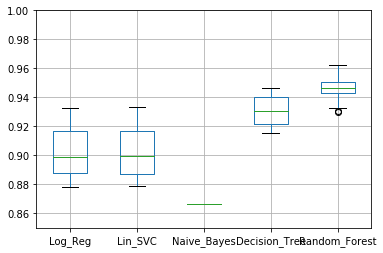

In [77]:
fit_eval(build_lda)

Use `components_` attribute of the LDA to find top 5 words of each topic and print them out.

In [74]:
X_train, _,_,_ = train_test_split(sms['text'], sms['label'], random_state=0, test_size=0.2, stratify=sms["label"])  
lda, cv = build_lda(X_train)

for i, topic in enumerate(lda.components_, start=1):
    sorting = np.argsort(topic)[::-1]
    feature_names = np.array(cv.get_feature_names())
    
    top_five_words = feature_names[sorting][:5]
    top_five_words = " ".join(top_five_words)
    
    print('Top in '+str(i)+':', top_five_words)

Top in 1: drive point account show expir
Top in 2: time night im home go
Top in 3: free txt ur latest phone
Top in 4: dont year know just new
Top in 5: lor ok wat got da
Top in 6: pls right prize won send
Top in 7: start place big sent told
Top in 8: ok contact landlin ya video
Top in 9: meet work tri month weekend
Top in 10: week ur tone free nokia
Top in 11: ill sorri later im yeah
Top in 12: come tonight tomorrow pick finish
Top in 13: ltgt hi oh im got
Top in 14: today your birthday class late
Top in 15: free repli text nokia txt
Top in 16: know leav dear ok dont
Top in 17: number thank mobil claim better
Top in 18: stop text send love use
Top in 19: wish life didnt need love
Top in 20: ur guy dont care just
Top in 21: good day think morn great
Top in 22: that did way love fine
Top in 23: like friend just bring im
Top in 24: hey buy say ltgt know
Top in 25: im lol just happen car


In a few sentences describe your observations with regard to comparing vanilla TF-IDF vs adding a LDA on top of a count vectorizer.

The TF-IDF has a higher accuracy than LDA. 